In [40]:
import pandas as pd

## Загружаем данные

In [41]:
data_dir = '../data/random_data'

In [42]:
tracks = pd.read_csv('{}/tracks.csv'.format(data_dir), index_col=0)
artists = pd.read_csv('{}/artists.csv'.format(data_dir), index_col=0)
albums = pd.read_csv('{}/albums.csv'.format(data_dir), index_col=0)
transactions = pd.read_csv('{}/transactions.csv'.format(data_dir), index_col=0)
playlists = pd.read_csv('{}/playlists.csv'.format(data_dir), index_col=0)

К каждой транзакции добавляем признаки популярность(popular), артист(artistid), альбом(albumid) трека, имя плейлиста(name), num_followers плейлиста

In [43]:
def get_full_dataset(transactions, tracks, playlists):
    full_dataset = pd.merge(transactions, tracks, how='left', on='trackid')
    full_dataset = pd.merge(full_dataset, playlists, how='left', on='pid')
    return full_dataset

Рейтинг определяем единичкой

In [44]:
full_dataset = get_full_dataset(transactions, tracks, playlists)
full_dataset['rating'] = 1
full_dataset.head()

,pid,trackid,popular,artistid,albumid,name,num_followers,rating
0,822032,2283,3384,1151,1618,party time,1,1
1,822032,2288,4339,1152,1622,party time,1,1
2,822032,907,4992,500,687,party time,1,1
3,822032,2289,1822,503,690,party time,1,1
4,822032,910,2160,503,690,party time,1,1


In [45]:
full_dataset.shape

(210950, 8)

Импортируем основные модули

In [46]:
from polara.recommender.models import RecommenderModel
from polara.recommender.data import RecommenderData
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
from scipy import sparse
from polara.recommender.coldstart.data import ItemColdStartData
from polara.recommender.models import SVDModel

### Описания модели

- $\textbf{R}$ - матрица playlist-track
- $\textbf{X}$ - матрица playlist-feuture
- $\textbf{A}$ - матрица близости плейлистов
- $\textbf{D}$ - диагональная матрица суммы строк $\textbf{A}$
- $\textbf{L} = D - A$ - лапласиан

$$J = \frac{1}{2}[\alpha||\textbf{R} - \textbf{UV}||_F^2 + (1 - \alpha)||\textbf{X} - \textbf{UH}||_F^2 + \beta Tr(\textbf{U}^T\textbf{LU}) + \lambda(||\textbf{U}||_F^2 + ||\textbf{V}||_F^2 + ||\textbf{H}||_F^2]$$

$$arg \min_{\textbf{U}, \textbf{V}, \textbf{H}} J$$
$$s.t. U \geq 0, V \geq 0, H \geq 0$$

Обновление $\textbf{U}, \textbf{V} , \textbf{H}$:

- $$U = U * \frac{\alpha\textbf{R}\textbf{V}^T + (1 -\alpha)\textbf{X}\textbf{H}^T + \beta\textbf{AU}}{\alpha\textbf{UV}\textbf{V}^T + (1 - \alpha)\textbf{UH}\textbf{H}^T + \beta\textbf{DU} + \lambda\textbf{U}}$$
- $$V = V * \frac{\alpha\textbf{U}^T\textbf{R}}{\alpha\textbf{U}^T\textbf{UV} + \lambda\textbf{V}}$$
- $$H = H * \frac{(1 - \alpha)\textbf{U}^T\textbf{X}}{(1 - \alpha)\textbf{U}^T\textbf{UH} + \lambda\textbf{H}}$$

$*$ - поэлементное умножение
$\frac{\dots}{\dots}$ - поэлементное деление

### Класс LocalCollectiveEmbeddings

- get_train_content - получить признаки транзакций, content_data - df с признаками
- get_content_shape - возвращает количество столбцов для каждого признака
- get_training_content_matrix - возвращает матрицу features $n \times v$ где n - кол-во плейлистов, v - количество признаков
- get_test_content_matrix - аналогично для тестовой выборки
- construct_closeness_matrix - строит матрицу близости плейлистов для по признакому описанию
- update_factors - обновляет матрицы U, V, H по правилам выше
- build - возвращает матрицу факторов плейлистов, треков, признаков
    - аргументы df с признаками, параметры модели, maxiter, verbose

In [47]:
class LocalCollectiveEmbeddings(RecommenderModel):
    import scipy.sparse
    
    def __init__(self, *args, **kwargs):
        super(LocalCollectiveEmbeddings, self).__init__(*args, **kwargs)
        self.method = 'LCE'
    
    def get_train_content(self, content_data):
        self.train_content = content_data
    
    def get_content_shape(self):
        self.content_shape = {}
        for col in self.train_content.columns:
            self.content_shape[col] = self.train_content[col].max() + 1

    def get_training_content_matrix(self):
        self.get_content_shape()
        idx_userid = self.data.training[self.data.fields[0]].values
        val = np.ones(self.data.training.shape[0])
        
        i = 0
        features = []
        
        for col in self.train_content.columns:
            idx_feature = self.train_content[col].values
            shp = (idx_userid.max() + 1, 
                   self.content_shape[col])
        
            features_new = sparse.csr_matrix((val, (idx_userid, idx_feature)), 
                                             shape=shp)
            
            if i == 0:
                features = features_new
            else:
                features = sparse.hstack((features, features_new))
            
            i += 1
        
        return features
    
    def get_test_content_matrix(self):
        idx_userid = self.data.test.testset[self.data.fields[0]].values
        val = np.ones(self.data.test.testset.shape[0])
        
        i = 0
        features = []
        
        for col in self.train_content.columns:
            idx_feature = self.data.test.testset[col].values
            shp = (idx_userid.max() + 1, 
                   self.content_shape[col])
        
            features_new = sparse.csr_matrix((val, (idx_userid, idx_feature)), 
                                             shape=shp)
            
            if i == 0:
                features = features_new
            else:
                features = sparse.hstack((features, features_new))
            
            i += 1
        
        
        return features
        
        
    def construct_closeness_matrix(self, X, rank, binary=False):
        print ('Construct closeness matrix...')
        nbrs = NearestNeighbors(n_neighbors=1 + rank).fit(X)
        if binary:
            closeness_matrix = nbrs.kneighbors_graph(X)
        else:
            closeness_matrix = nbrs.kneighbors_graph(X, mode='distance')
        print ('Done.')
            
        return closeness_matrix
    
    def get_constant(self, R, X):
        trRtR = tr(R, R)
        trXtX = tr(X, X)
        return trRtR, trXtX
    
    def update_factors(self, R, X, U, V, H, A, D, 
                       alpha, beta, lamb):
        
        gamma = 1. - alpha
        
        UtU = U.T.dot(U)
        UtR = U.T.dot(R)
        UtX = U.T.dot(X)
        UtUV = UtU.dot(V)
        UtUH = UtU.dot(H)
        DU = D.dot(U)
        AU = A.dot(U)
        
        #update V
        V_1 = np.divide((alpha * UtR), 
                        (alpha * UtUV + lamb * V).maximum(1e-10))
        V = V.multiply(V_1)
            
        #update H
        H_1 = np.divide(
            (gamma * UtX), (gamma * UtUH + lamb * H).maximum(1e-10))
        H = H.multiply(H_1)
            
        # update U
        U_t1 = alpha * R.dot(V.T) + gamma * X.dot(H.T) + beta * AU
        U_t2 = alpha * U.dot(V.dot(V.T)) + gamma * \
        U.dot(H.dot(H.T)) + beta * DU + lamb * U
            
        U_t3 = np.divide(U_t1, (U_t2).maximum(1e-10))
        U = U.multiply(U_t3)
        
        #calculate oblective function without constant
        
        tr1 = alpha * ((-2.) * tr(V, UtR) + tr(V, UtUV))
        tr2 = gamma * ((-2.) * tr(H, UtX) + tr(H, UtUH))
        tr3 = beta * (tr(U, DU) - tr(U, AU))
        tr4 = lamb * (UtU.diagonal().sum() + tr(V, V) + tr(H, H))

        Obj = tr1 + tr2 + tr3 + tr4
        
        
        return U, V, H, Obj
        
        
        
    def build(self, content_data, 
              rank=10, alpha=0.1, beta=0.005, lamb=0.0001, 
              epsilon=0.01, seed=0,maxiter=150, verbose=True):
        
        self.get_train_content(content_data)
        
        R = self.get_training_matrix(dtype='float64')
        X = self.get_training_content_matrix()
        A = self.construct_closeness_matrix(X, rank, binary=True).tocsr()
        
        num_users = R.shape[0]
        num_items = R.shape[1]
        num_features = X.shape[1]
        
        U = np.abs(sparse.rand(num_users, rank, 0.99, 'csr', dtype=R.dtype, random_state=seed))
        V = np.abs(sparse.rand(rank, num_items, 0.99, 'csr', dtype=R.dtype, random_state=seed))
        H = np.abs(sparse.rand(rank, num_features, 0.99, 'csr', dtype=R.dtype, random_state=seed))
        
        
        #auxiliary constant   
        D = sparse.dia_matrix((A.sum(axis=0), 0), A.shape)
        trRtR, trXtX = self.get_constant(R, X)

        itNum = 1
        delta = 2.0 * epsilon

        ObjHist = []
        
        while True:

            U, V, H, Obj = self.update_factors(R, X, U, V, H, A, D, 
                                               alpha, beta, lamb)
            Obj += alpha*trRtR + (1. - alpha)*trXtX
            Obj = Obj / (num_users * num_features * num_items * rank)
            ObjHist.append(Obj)
            
            if itNum > 1:
                delta = abs(ObjHist[-1] - ObjHist[-2])
                if verbose:
                    print ("Iteration: ", itNum, "Objective: ", Obj, "Delta: ", delta)
                if itNum > maxiter or delta < epsilon:
                    break

            itNum += 1
            
        self.user_factors = U
        self.feature_factors = H 
        self.item_factors = V
        
        
    def slice_recommendations(self, test_data, shape, start, stop, test_users=None):
        slice_data = self._slice_test_data(test_data, start, stop)
        features = self.get_test_content_matrix()
        Ut = np.linalg.lstsq(self.feature_factors.T.toarray(), 
                             features.T.toarray(), rcond=-1)[0]
        R = Ut.T.dot(self.item_factors.toarray())
        return R, slice_data

In [48]:
def reindex_content(content_data, col, sort=True, inplace=True):
    grouper = content_data.groupby(col, sort=sort).grouper
    new_val = grouper.group_info[1]
    old_val = grouper.levels[0]
    print (new_val.shape, old_val.shape)
    val_transform = pd.DataFrame({'old': old_val, 'new': new_val})
    new_data = grouper.group_info[0]

    if inplace:
        result = val_transform
        content_data.loc[:, col] = new_data
    else:
        result = (new_data, val_transform)
    return result
        
def reindex_content_columns(content_data, columns):
    index_content = {}
    for col in columns:
        index_content[col] = reindex_content(content_data, col)
    return index_content

In [49]:
def tr(A, B):
    x = A.multiply(B)
    return (x.sum(axis=0)).sum(axis=1)

In [50]:
def cross_validation_lce(data, n_splits=5, seed=1, test_size=0.05, 
                         topk=500, rank=10, maxiter=10000, epsilon=0.1, 
                         alpha=.9, lamb=0.001, beta=0.05):
    
    index_content = reindex_content_columns(data, ['artistid', 'albumid'])
    
    kf = KFold(n_splits=n_splits, random_state=seed)
    i = 1
    scores_lce = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    scores_svd = {'precision': [], 'recall': [], 'miss_rate': [], 'nDCG': []}
    for users_ids, unseen_users_ids in kf.split(data['pid'].drop_duplicates()):
        print('=========================Fold {}============================='.format(i))
        i += 1
        users = data['pid'].drop_duplicates().values[users_ids]
        unseen_users = data['pid'].drop_duplicates().values[unseen_users_ids]
        train = data.query('pid in @users')
        test = data.query('pid in @unseen_users')
        train_albums = train.albumid.unique()
        train_artists = train.artistid.unique()
        test = test.query('albumid in @train_albums')
        test = test.query('artistid in @train_artists')
        test_sampled = test.sample(frac=1-test_size, random_state=seed).sort_values('pid')
        test_holdout = test[~test.index.isin(test_sampled.index)]
        
        data_model = RecommenderData(train,'pid', 'trackid', 'rating', seed=seed)
        data_model.prepare_training_only()
        lce = LocalCollectiveEmbeddings(data_model)
        %time lce.build(train[['artistid']], verbose=False, rank=rank, maxiter=maxiter, alpha=alpha, epsilon=epsilon, beta=beta, lamb=lamb)
        
        svd = SVDModel(data_model)
        svd.rank = rank
        svd.build()
        
        data_model.set_test_data(testset=test_sampled, holdout=test_holdout, warm_start=True)
        lce.topk = topk
        lce.swith_positive = 1
        
        svd.topk = topk
        svd.swith_positive = 1
        
        hits = lce.evaluate()
        relevance = lce.evaluate('relevance')
        ranking = lce.evaluate('ranking')
        
        scores_lce['precision'].append(relevance.precision)
        scores_lce['recall'].append(relevance.recall)
        scores_lce['miss_rate'].append(relevance.miss_rate)
        scores_lce['nDCG'].append(ranking.nDCG)
        
        print('lce hits', hits)
        
        hits = svd.evaluate()
        relevance = svd.evaluate('relevance')
        ranking = svd.evaluate('ranking')        
        
        scores_svd['precision'].append(relevance.precision)
        scores_svd['recall'].append(relevance.recall)
        scores_svd['miss_rate'].append(relevance.miss_rate)
        scores_svd['nDCG'].append(ranking.nDCG)
        
        print ('svd hits', hits)
        
    result_lce = pd.DataFrame(scores_lce)
    result_svd = pd.DataFrame(scores_svd)
    return result_lce, result_svd

In [51]:
import tqdm

In [52]:
ranks = [5, 10, 15, 25, 50]
recall_lce, recall_svd = [], []
nDCG_lce, nDCG_svd = [], []
precision_lce, precision_svd  = [], []
miss_rate_lce, miss_rate_svd= [], []
for rank in tqdm.tqdm(ranks):
    print('             ===========rank={}============='.format(rank))
    result_lce, result_svd = cross_validation_lce(full_dataset,n_splits=5, topk=10, test_size=0.1, 
                                                  rank=rank, alpha=0.9, epsilon=1e-12, 
                                                  lamb=1, beta=0.05)
    recall_lce.append(result_lce.recall.mean())
    nDCG_lce.append(result_lce.nDCG.mean())
    precision_lce.append(result_lce.precision.mean())
    miss_rate_lce.append(result_lce.miss_rate.mean())
    recall_svd.append(result_svd.recall.mean())
    nDCG_svd.append(result_svd.nDCG.mean())
    precision_svd.append(result_svd.precision.mean())
    miss_rate_svd.append(result_svd.miss_rate.mean())

  0%|          | 0/5 [00:00<?, ?it/s]

             ===========rank=5=============
(4243,) (4243,)
(6824,) (6824,)
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 3.14 s, sys: 408 ms, total: 3.54 s
Wall time: 3.61 s
PureSVD training time: 0.18608613000105834s
107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=255, false_positive=11925, true_negative=None, false_negative=3971)
svd hits Hits(true_positive=291, false_positive=11889, true_negative=None, false_negative=3935)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 3.83 s, sys: 408 ms, total: 4.24 s
Wall time: 4.24 s
PureSVD training time: 0.06546096899910481s
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=228, false_positive=11812, true_negative=None, false_negative=3852)
svd hits Hits(true_positive=275, false_positive=11765, true_negative=None, false_negative=3805)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 12.2 s, sys: 450 ms, total: 12.7 s
Wall time: 12.7 s
PureSVD training time: 0.0714848180032277s
98 unique trackid's within 109 testset interactions were filtered. Reason: not in the training data.
9 unique trackid's within 9 holdout interactions were filtered. Reason: not in the training data.
304 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=240, false_positive=12020, true_negative=None, false_negative=3947)
svd hits Hits(true_positive=283, false_positive=11977, true_negative=None, false_negative=3904)
=========================Fold 4=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 10.3 s, sys: 464 ms, total: 10.8 s
Wall time: 10.8 s
PureSVD training time: 0.08086741599981906s
93 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
330 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=215, false_positive=11755, true_negative=None, false_negative=3853)
svd hits Hits(true_positive=250, false_positive=11720, true_negative=None, false_negative=3818)
=========================Fold 5=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 8.95 s, sys: 372 ms, total: 9.32 s
Wall time: 9.33 s
PureSVD training time: 0.11403649699786911s
101 unique trackid's within 116 testset interactions were filtered. Reason: not in the training data.
12 unique trackid's within 12 holdout interactions were filtered. Reason: not in the training data.
315 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=257, false_positive=11893, true_negative=None, false_negative=3900)


 20%|██        | 1/5 [00:48<03:13, 48.32s/it]

svd hits Hits(true_positive=296, false_positive=11854, true_negative=None, false_negative=3861)
             ===========rank=10=============
(4243,) (4243,)
(6824,) (6824,)
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 21.8 s, sys: 400 ms, total: 22.2 s
Wall time: 22.2 s
PureSVD training time: 0.13628845399944112s
107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=342, false_positive=11838, true_negative=None, false_negative=3884)
svd hits Hits(true_positive=420, false_positive=11760, true_negative=None, false_negative=3806)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 24.3 s, sys: 480 ms, total: 24.8 s
Wall time: 24.8 s
PureSVD training time: 0.11095396699965931s
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=328, false_positive=11712, true_negative=None, false_negative=3752)
svd hits Hits(true_positive=409, false_positive=11631, true_negative=None, false_negative=3671)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 4.78 s, sys: 416 ms, total: 5.2 s
Wall time: 5.19 s
PureSVD training time: 0.09140758399735205s
98 unique trackid's within 109 testset interactions were filtered. Reason: not in the training data.
9 unique trackid's within 9 holdout interactions were filtered. Reason: not in the training data.
304 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=352, false_positive=11908, true_negative=None, false_negative=3835)
svd hits Hits(true_positive=420, false_positive=11840, true_negative=None, false_negative=3767)
=========================Fold 4=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 22.8 s, sys: 436 ms, total: 23.2 s
Wall time: 23.2 s
PureSVD training time: 0.0860151130000304s
93 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
330 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=293, false_positive=11677, true_negative=None, false_negative=3775)
svd hits Hits(true_positive=382, false_positive=11588, true_negative=None, false_negative=3686)
=========================Fold 5=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 19.6 s, sys: 380 ms, total: 20 s
Wall time: 20 s
PureSVD training time: 0.09130643000025884s
101 unique trackid's within 116 testset interactions were filtered. Reason: not in the training data.
12 unique trackid's within 12 holdout interactions were filtered. Reason: not in the training data.
315 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=382, false_positive=11768, true_negative=None, false_negative=3775)


 40%|████      | 2/5 [02:30<03:46, 75.45s/it]

svd hits Hits(true_positive=421, false_positive=11729, true_negative=None, false_negative=3736)
             ===========rank=15=============
(4243,) (4243,)
(6824,) (6824,)
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 34.7 s, sys: 368 ms, total: 35.1 s
Wall time: 35 s
PureSVD training time: 0.11065379200226744s
107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=395, false_positive=11785, true_negative=None, false_negative=3831)
svd hits Hits(true_positive=516, false_positive=11664, true_negative=None, false_negative=3710)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 19.6 s, sys: 424 ms, total: 20 s
Wall time: 20 s
PureSVD training time: 0.11894948899862356s
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=398, false_positive=11642, true_negative=None, false_negative=3682)
svd hits Hits(true_positive=480, false_positive=11560, true_negative=None, false_negative=3600)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 25 s, sys: 420 ms, total: 25.4 s
Wall time: 25.4 s
PureSVD training time: 0.1189893619994109s
98 unique trackid's within 109 testset interactions were filtered. Reason: not in the training data.
9 unique trackid's within 9 holdout interactions were filtered. Reason: not in the training data.
304 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=392, false_positive=11868, true_negative=None, false_negative=3795)
svd hits Hits(true_positive=497, false_positive=11763, true_negative=None, false_negative=3690)
=========================Fold 4=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 24 s, sys: 376 ms, total: 24.4 s
Wall time: 24.4 s
PureSVD training time: 0.11407776900159661s
93 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
330 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=360, false_positive=11610, true_negative=None, false_negative=3708)
svd hits Hits(true_positive=454, false_positive=11516, true_negative=None, false_negative=3614)
=========================Fold 5=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 22.9 s, sys: 412 ms, total: 23.3 s
Wall time: 23.3 s
PureSVD training time: 0.1338884169999801s
101 unique trackid's within 116 testset interactions were filtered. Reason: not in the training data.
12 unique trackid's within 12 holdout interactions were filtered. Reason: not in the training data.
315 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=411, false_positive=11739, true_negative=None, false_negative=3746)


 60%|██████    | 3/5 [04:46<03:10, 95.45s/it]

svd hits Hits(true_positive=524, false_positive=11626, true_negative=None, false_negative=3633)
             ===========rank=25=============
(4243,) (4243,)
(6824,) (6824,)
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 32.7 s, sys: 392 ms, total: 33.1 s
Wall time: 33.1 s
PureSVD training time: 0.2102266830006556s
107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=468, false_positive=11712, true_negative=None, false_negative=3758)
svd hits Hits(true_positive=639, false_positive=11541, true_negative=None, false_negative=3587)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 31.5 s, sys: 551 ms, total: 32 s
Wall time: 32.1 s
PureSVD training time: 0.21909363099985057s
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=430, false_positive=11610, true_negative=None, false_negative=3650)
svd hits Hits(true_positive=594, false_positive=11446, true_negative=None, false_negative=3486)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 37.9 s, sys: 476 ms, total: 38.4 s
Wall time: 38.4 s
PureSVD training time: 0.2578803059986967s
98 unique trackid's within 109 testset interactions were filtered. Reason: not in the training data.
9 unique trackid's within 9 holdout interactions were filtered. Reason: not in the training data.
304 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=435, false_positive=11825, true_negative=None, false_negative=3752)
svd hits Hits(true_positive=599, false_positive=11661, true_negative=None, false_negative=3588)
=========================Fold 4=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 35.2 s, sys: 448 ms, total: 35.7 s
Wall time: 35.7 s
PureSVD training time: 0.25624100099958014s
93 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
330 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=400, false_positive=11570, true_negative=None, false_negative=3668)
svd hits Hits(true_positive=557, false_positive=11413, true_negative=None, false_negative=3511)
=========================Fold 5=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 34 s, sys: 368 ms, total: 34.3 s
Wall time: 34.3 s
PureSVD training time: 0.2123699769981613s
101 unique trackid's within 116 testset interactions were filtered. Reason: not in the training data.
12 unique trackid's within 12 holdout interactions were filtered. Reason: not in the training data.
315 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=474, false_positive=11676, true_negative=None, false_negative=3683)


 80%|████████  | 4/5 [07:49<01:57, 117.30s/it]

svd hits Hits(true_positive=605, false_positive=11545, true_negative=None, false_negative=3552)
             ===========rank=50=============
(4243,) (4243,)
(6824,) (6824,)
=========================Fold 1=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 1min 31s, sys: 455 ms, total: 1min 31s
Wall time: 1min 31s
PureSVD training time: 0.5807160489966918s
107 unique trackid's within 120 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
312 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=445, false_positive=11735, true_negative=None, false_negative=3781)
svd hits Hits(true_positive=755, false_positive=11425, true_negative=None, false_negative=3471)
=========================Fold 2=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 1min 30s, sys: 465 ms, total: 1min 31s
Wall time: 1min 31s
PureSVD training time: 1.2013301529987075s
91 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
326 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=459, false_positive=11581, true_negative=None, false_negative=3621)
svd hits Hits(true_positive=715, false_positive=11325, true_negative=None, false_negative=3365)
=========================Fold 3=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 1min 16s, sys: 588 ms, total: 1min 17s
Wall time: 1min 17s
PureSVD training time: 0.6994274819990096s
98 unique trackid's within 109 testset interactions were filtered. Reason: not in the training data.
9 unique trackid's within 9 holdout interactions were filtered. Reason: not in the training data.
304 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=432, false_positive=11828, true_negative=None, false_negative=3755)
svd hits Hits(true_positive=761, false_positive=11499, true_negative=None, false_negative=3426)
=========================Fold 4=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 1min 47s, sys: 483 ms, total: 1min 48s
Wall time: 1min 48s
PureSVD training time: 0.6676263290028146s
93 unique trackid's within 102 testset interactions were filtered. Reason: not in the training data.
15 unique trackid's within 15 holdout interactions were filtered. Reason: not in the training data.
1 pid's were filtered out from holdout. Reason: inconsistent with testset.
330 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=475, false_positive=11495, true_negative=None, false_negative=3593)
svd hits Hits(true_positive=675, false_positive=11295, true_negative=None, false_negative=3393)
=========================Fold 5=============================
Preparing data...
Done.
Construct closeness matrix...
Done.


/usr/local/lib/python3.5/dist-packages/scipy/sparse/compressed.py:538: SparseEfficiencyWarning: Taking maximum (minimum) with > 0 (< 0) number results to a dense matrix.
  SparseEfficiencyWarning)


CPU times: user 1min 38s, sys: 800 ms, total: 1min 39s
Wall time: 1min 39s
PureSVD training time: 1.3449933289994078s
101 unique trackid's within 116 testset interactions were filtered. Reason: not in the training data.
12 unique trackid's within 12 holdout interactions were filtered. Reason: not in the training data.
315 pid's were filtered out from testset. Reason: inconsistent with holdout.
lce hits Hits(true_positive=443, false_positive=11707, true_negative=None, false_negative=3714)


100%|██████████| 5/5 [15:49<00:00, 189.82s/it]

svd hits Hits(true_positive=722, false_positive=11428, true_negative=None, false_negative=3435)


In [53]:
import matplotlib.pyplot as plt

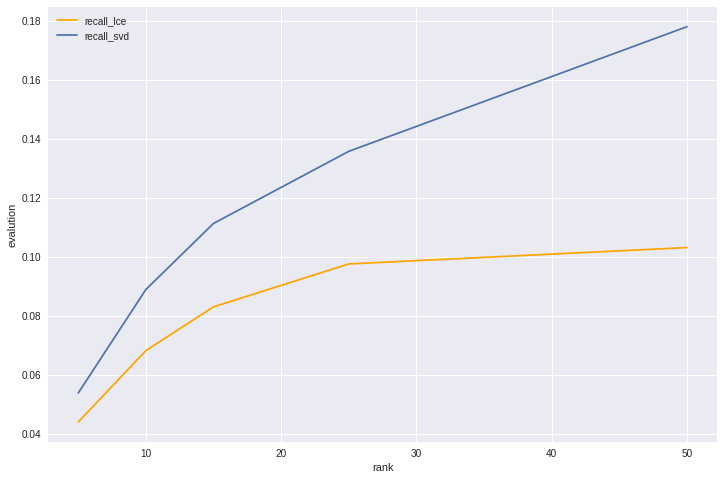

In [54]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, recall_lce, 'orange', label='recall_lce')
plt.plot(ranks, recall_svd, label='recall_svd')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()

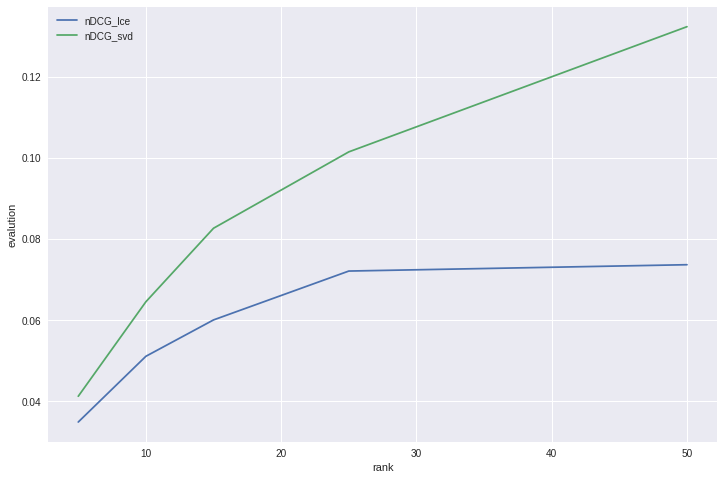

In [55]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.plot(ranks, nDCG_lce,label='nDCG_lce')
plt.plot(ranks, nDCG_svd, label='nDCG_svd')
plt.ylabel('evalution')
plt.xlabel('rank')
plt.legend()
plt.show()